# <b>EDA (SUBSET 1/4)</b>

In [1]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data preparation

The netflix data is split into 4 files: combined_data_X.txt

The data is formatted as such:

movie_id_1: \
user1, rating, date\
user2, rating, date\
...

movie_id_2:\
user1, rating, date\
user2, rating, date\
...

movie_id_X:\
userX, rating, date\
userY rating, date\
...

From this raw data, we turn this into a flat Pandas Dataframe, with each row being one observation (1 rating).

Our movie titles are provided in movie_titles.csv; however, some of the titles contain one or more commas which is causing parsing issues with the csv. We won't be able to parse it with pd.read_csv, instead we'll parse it line by line

In [3]:
df_raw = pd.read_parquet('/content/drive/MyDrive/Netflix_Prize/combined_data_1.parquet')

In [4]:
df = df_raw.drop('index', axis=1)

In [5]:
# small subset of 4499 movies (1/4 of the entire data)
df

,user_id,rating,date,movie_id
0,1488844,3.0,2005-09-06,1
1,822109,5.0,2005-05-13,1
2,885013,4.0,2005-10-19,1
3,30878,4.0,2005-12-26,1
4,823519,3.0,2004-05-03,1
...,...,...,...,...
24053759,2591364,2.0,2005-02-16,4499
24053760,1791000,2.0,2005-02-10,4499
24053761,512536,5.0,2005-07-27,4499
24053762,988963,3.0,2005-12-20,4499


from matplotlib import pyplot as plt
df['user_id'].plot(kind='hist', bins=20, title='user_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['rating'].plot(kind='hist', bins=20, title='rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['movie_id'].plot(kind='hist', bins=20, title='movie_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [32]:
nan_df = df[df.isna().any(axis=1)]

In [33]:
nan_df

,user_id,rating,date,movie_id


In [6]:
df.head()

,user_id,rating,date,movie_id
0,1488844,3.0,2005-09-06,1
1,822109,5.0,2005-05-13,1
2,885013,4.0,2005-10-19,1
3,30878,4.0,2005-12-26,1
4,823519,3.0,2004-05-03,1


In [7]:
import csv
import pandas as pd

path = '/content/drive/MyDrive/Netflix_Prize/movie_titles.csv'

records = []

with open(path, encoding='utf-8') as f:
    reader = csv.reader(f)
    for row in reader:
        movie_id = int(row[0])
        year = row[1]
        title = ','.join(row[2:]).strip()
        records.append((movie_id, year, title))
        if movie_id == 500:
            break

movie_titles = pd.DataFrame(records, columns=['movie_id', 'year', 'title'])

movie_titles['year'] = movie_titles['year'].astype(int)

In [8]:
user_counts = df['user_id'].value_counts()


# We can see through this that ~370000 unique users provided a rating
print("Number of users rated:", len(user_counts))

Number of users rated: 470758


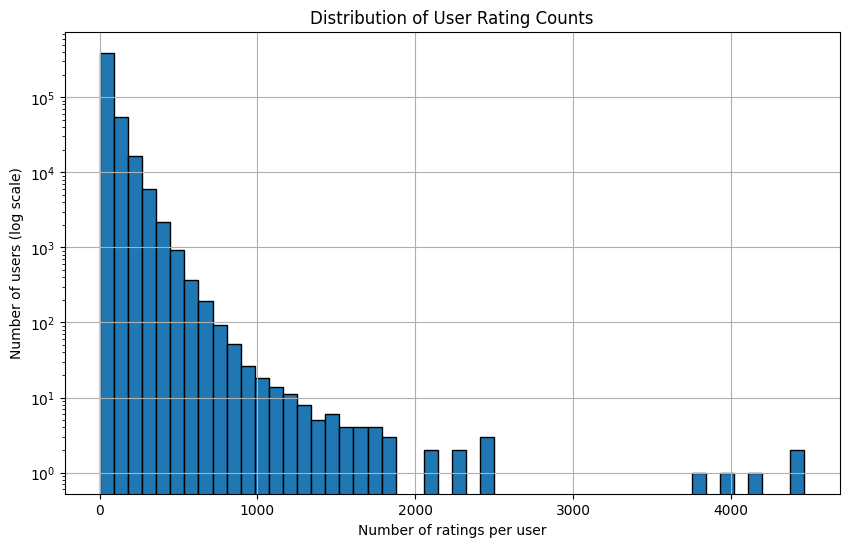

In [9]:
import matplotlib.pyplot as plt

user_counts = df['user_id'].value_counts()

plt.figure(figsize=(10, 6))
plt.hist(user_counts, bins=50, edgecolor='black', log=True)
plt.xlabel("Number of ratings per user")
plt.ylabel("Number of users (log scale)")
plt.title("Distribution of User Rating Counts")
plt.grid(True)
plt.show()

We see that most users tend to not give too many ratings, even though this is only a subset of the data, we can expect the rest of the data to be similarly sparse. We'll account for this sparsity in our training.

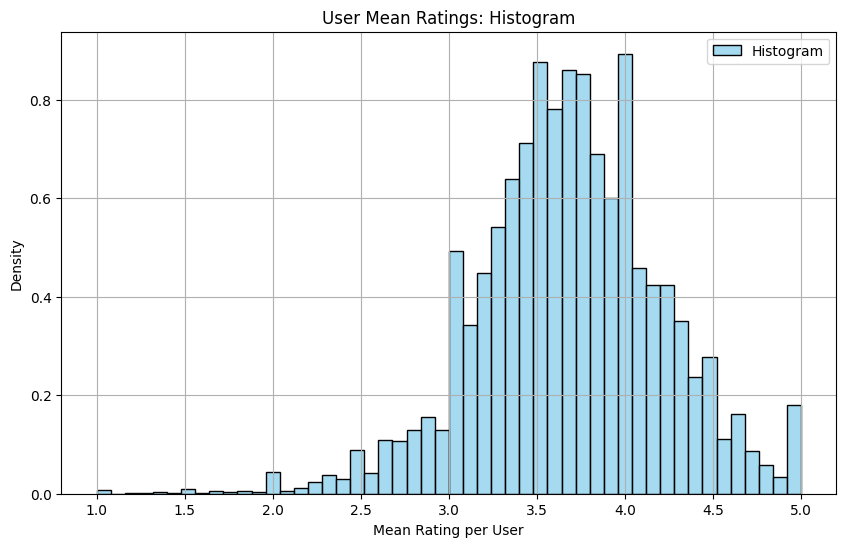

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

user_stats = df.groupby('user_id')['rating'].agg(['mean', 'std'])
user_stats = user_stats.dropna()  # drop users with only one rating (std = NaN)

plt.figure(figsize=(10, 6))

# Histogram (density-scaled)
sns.histplot(user_stats['mean'], bins=50, stat="density", color='skyblue', edgecolor='black', kde=False, label='Histogram')

plt.xlabel("Mean Rating per User")
plt.ylabel("Density")
plt.title("User Mean Ratings: Histogram")
plt.legend()
plt.grid(True)
plt.show()

This histogram shows that on average, users tend to rate movies positively (rating > 3.0).

Moreover there are spikes on the multiples of .5, with the highest spike being 4.0. These show that a lot of users don't show a lot of variation in their rating. Users that tend to give ~4.0 ratings seem to give ~4.0 ratings consistently.

### Sparsity: The Cold-Start Problem

We'll take a look at the sparsity of the data, i.e. how "full" our matrix of users x movies is

In [11]:
### Sparsity
n_users = df['user_id'].nunique()
n_movies = df['movie_id'].nunique()
n_ratings = len(df)

total_possible = n_users * n_movies
sparsity = 1 - (n_ratings / total_possible)

print(f"Users: {n_users}")
print(f"Movies: {n_movies}")
print(f"Actual ratings: {n_ratings}")
print(f"Matrix size: {total_possible}")
print(f"Sparsity: {sparsity:.4%}")

Users: 470758
Movies: 4499
Actual ratings: 24053764
Matrix size: 2117940242
Sparsity: 98.8643%


We obtain a value of ~98.5% sparsity which is expected for recommender data. Many movies are niche, meaning they don't get rated as often, many users don't rate all the movies they watch. Let's sample a part of our matrix to visualize this sparsity.

In [12]:
# top 100 sample
top_users = df['user_id'].value_counts().head(100).index
top_movies = df['movie_id'].value_counts().head(100).index

sample_df = df[df['user_id'].isin(top_users) & df['movie_id'].isin(top_movies)]

matrix = sample_df.pivot(index='user_id', columns='movie_id', values='rating').notnull().astype(int)

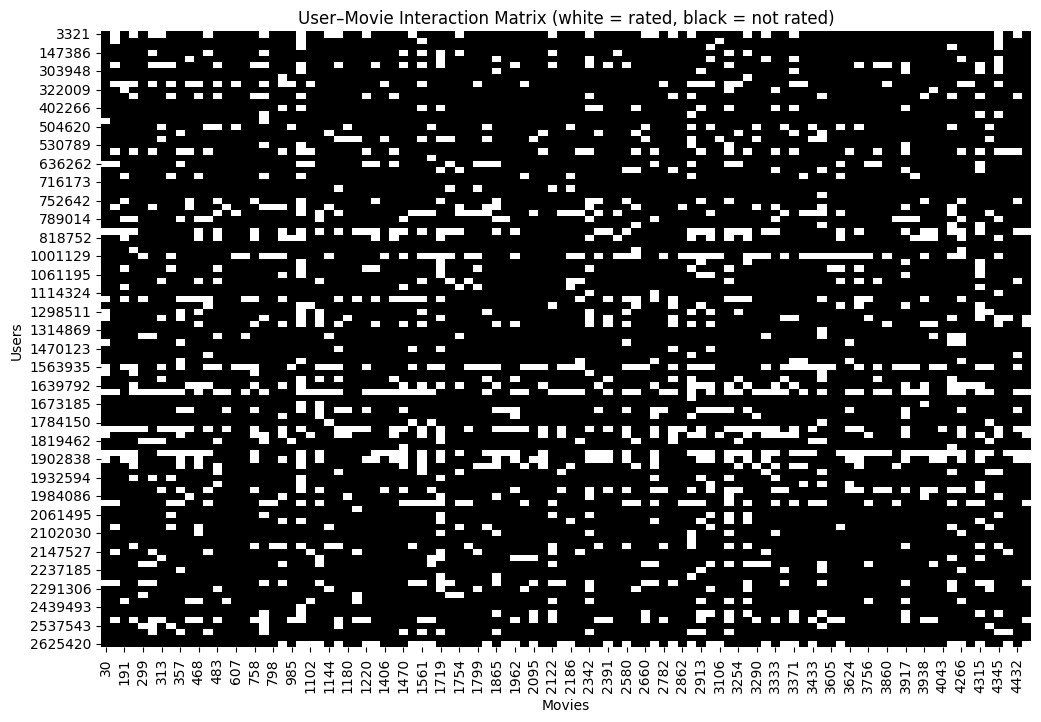

In [13]:
plt.figure(figsize=(12, 8))
sns.heatmap(matrix, cmap='Greys', cbar=False)
plt.title("User–Movie Interaction Matrix (white = rated, black = not rated)")
plt.xlabel("Movies")
plt.ylabel("Users")
plt.show()

This level of sparsity is one of the main challenges of recommender system. When so little data is available, algorithms struggle to extract any pattern from the data: this is known as the "cold-start problem."

The problem usually occurs when there's a new platform, and users have not yet have time to give us enough data for training. As collaborative filtering relies heavily on past behavior, we look at a few solutions:

1. <b>Content-based filtering:</b> Recommend based on user or item features (e.g., genre, age, location) instead of past ratings
2. <b>Hybrid models:</b> Combine collaborative + content-based recommendations
3. <b>Onboarding questionnaires:</b> Ask new users to rate a few items or select preferences
4. <b>Popular item fallback:</b> Recommend trending or universally liked items initially
5. <b>Cold-start-aware learning:</b> Use side information (e.g., metadata, text, embeddings) in neural models or GNNs

### Most active raters
Let's zoom in and look at our most active raters, with more than 400 ratings

In [14]:
active_users = df['user_id'].value_counts()

active_users = active_users[active_users > 200].index

In [15]:
active_df = df[df['user_id'].isin(active_users)]
active_df.head(5)

,user_id,rating,date,movie_id
0,1488844,3.0,2005-09-06,1
3,30878,4.0,2005-12-26,1
7,1248029,3.0,2004-04-22,1
19,372233,5.0,2005-11-23,1
20,1080361,3.0,2005-03-28,1


In [16]:
# Average rating point

active_df['rating'].mean()

np.float64(3.4422674569265395)

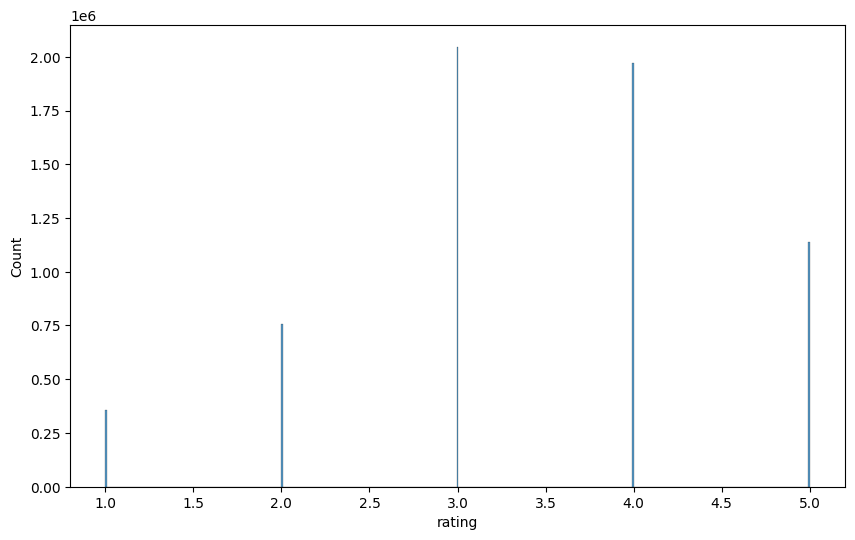

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(data=active_df['rating'])

plt.show()

Judging from the histogram and the average, we see that our most active users are generally very critical which aligns with our expectations--users are more likely to leave a rating if they're unhappy with the movie.

### Movies

Let's next look at the best and worst movies, additionally, we can also explore:
- Most and least rated
- Cult favourites: movies with low number of rating but high average rating
- Polarizing: movies with the biggest variance in rating, high number of very high ratings and very low ratings
- Bias towards older or newer movies

In [18]:
movies_df = df.groupby('movie_id').agg(
    avg_rating=('rating', 'mean'),
    count=('rating', 'count')
)

movies_df.head(5)

,avg_rating,count
movie_id,,
1,3.749543,547
2,3.558621,145
3,3.641153,2012
4,2.739437,142
5,3.919298,1140


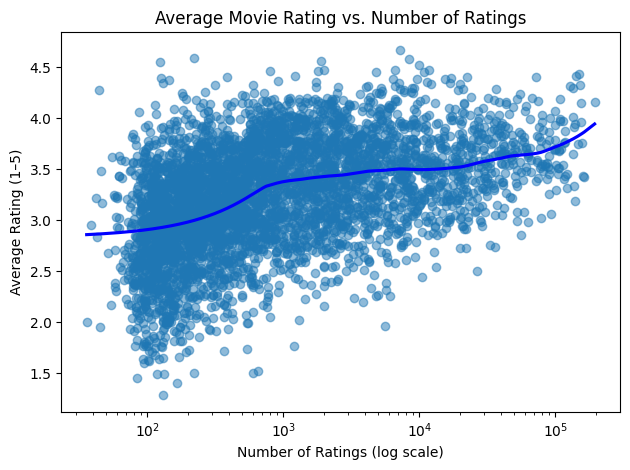

In [19]:
sns.regplot(
    data=movies_df,
    x='count',
    y='avg_rating',
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'blue'},
    lowess=True
)

plt.xscale('log')
plt.xlabel('Number of Ratings (log scale)')
plt.ylabel('Average Rating (1–5)')
plt.title('Average Movie Rating vs. Number of Ratings')
plt.tight_layout()
plt.show()

On top we see a movie that achieved 4.5 average rating despite a relatively low number of ratings, this is our cult favourite:

In [20]:
cult_fav_i = movies_df[movies_df['avg_rating'] >= 4.5].index[0]

print("Cult favourite index:", cult_fav_i)

Cult favourite index: 13


In [21]:
movie_titles[movie_titles['movie_id']==cult_fav_i]['title'].values[0]

'Lord of the Rings: The Return of the King: Extended Edition: Bonus Material'

It makes sense since only people who loves Lord of the Rings would watch the bonus material and leave positive ratings!

Let's look at those polarizing movies next, people loved them or hated them. We'll look at movies with a decent amount of ratings, and then sort them by highest standard deviation (variance).

In [22]:
polarizing = df.groupby('movie_id').agg(
    avg_rating=('rating', 'mean'),
    std=('rating', 'std'),
    count=('rating', 'count')
)

#filter out low count and sort by std

polarizing = polarizing[polarizing['count'] > 5000]

polarizing = polarizing.sort_values(by='std', ascending=False)

# merge with titles
polarizing = polarizing.merge(movie_titles, on='movie_id', how='left')

In [23]:
polarizing.head(5)

,movie_id,avg_rating,std,count,year,title
0,248,3.633339,1.327085,6161,2001.0,Michael Moore's The Awful Truth: Season 2
1,3999,3.946112,1.320432,9427,NaN,NaN
2,8,3.189805,1.314537,14910,2004.0,What the #$*! Do We Know!?
3,3151,3.398300,1.302506,116362,NaN,NaN
4,1741,3.910891,1.298985,10605,NaN,NaN


According to our filters, the most polarizing show is "Touched by an Angel: Season 1." Its rating was 3.69±1.42 which isn't extremely polarizing but shows some people thought it was very very good and some think its alright.

We can also look at other biases in the data, for example, do people generally prefer older movies?

In [24]:
# create movie_age df and merge with titles to get names and years

movie_age = df.groupby('movie_id').agg(
    avg_rating=('rating', 'mean'),
    count=('rating', 'count')
)

movie_age = movie_age.merge(movie_titles, on='movie_id', how='left')

movie_age['year'] = pd.to_numeric(movie_age['year'], errors='coerce')
movie_age = movie_age.dropna(subset=['year'])

# filter out obscure movies
movie_age = movie_age[movie_age['count'] > 10000]


In [25]:
movie_age.head()

,movie_id,avg_rating,count,year,title
7,8,3.189805,14910,2004.0,What the #$*! Do We Know!?
17,18,3.784369,10722,1994.0,Immortal Beloved
27,28,3.823254,39752,2002.0,Lilo and Stitch
29,30,3.761842,118413,2003.0,Something's Gotta Give
57,58,3.612008,17405,1996.0,Dragonheart


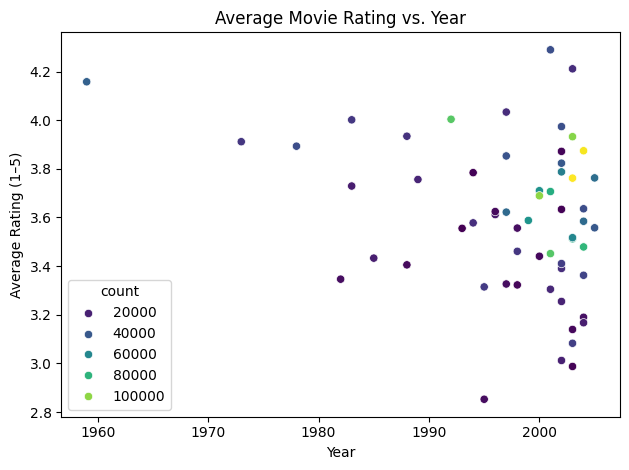

In [26]:
sns.scatterplot(
    data=movie_age,
    x='year',
    y='avg_rating',
    hue='count',
    palette='viridis'
)

plt.xlabel('Year')
plt.ylabel('Average Rating (1–5)')
plt.title('Average Movie Rating vs. Year')
plt.tight_layout()
plt.show()

### Movie Age Effect on Rating

We can look at how the movie's age at the time of a rating may affect its rating score. Are newer movies rated better? worse?

In [27]:
movie_age = df.merge(movie_titles, on="movie_id")[['user_id','rating','date','movie_id','year']]

movie_age.columns = ['user_id', 'rating', 'date_rated', 'movie_id', 'year_released']

movie_age['year_released'] = movie_age['year_released']

movie_age['year_rated'] = movie_age['date_rated'].dt.year

movie_age['age'] = movie_age['year_rated'] - movie_age['year_released']

movie_age.head()

,user_id,rating,date_rated,movie_id,year_released,year_rated,age
0,1488844,3.0,2005-09-06,1,2003,2005,2
1,822109,5.0,2005-05-13,1,2003,2005,2
2,885013,4.0,2005-10-19,1,2003,2005,2
3,30878,4.0,2005-12-26,1,2003,2005,2
4,823519,3.0,2004-05-03,1,2003,2004,1


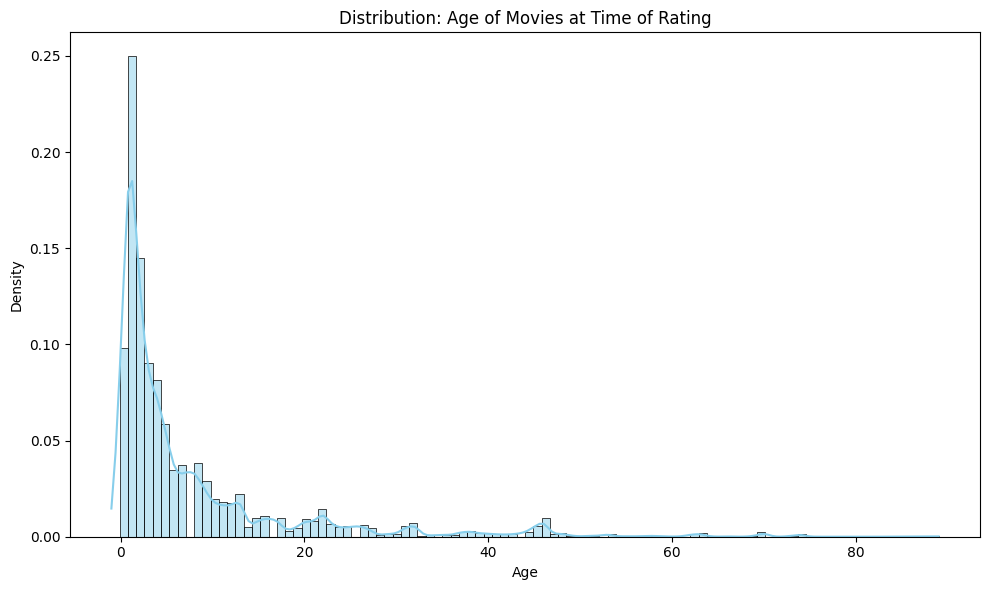

In [28]:
plt.figure(figsize=(10,6))
sns.histplot(movie_age['age'], bins=100, kde=True, stat='density', color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Distribution: Age of Movies at Time of Rating')
plt.tight_layout()
plt.show()

It seems there are some -1 age in our data. Looking at the data these ratings are often made towards the end of the year. This is possibly a disagreement between the netflix prize dataset and the movie_titles.csv that they provided. We'll remove these for now, since theres not many of them.

In [29]:
movie_age = movie_age[movie_age['age'] >= 0]

In [30]:
avg_rating_per_age = pd.DataFrame(movie_age.groupby('age').mean()['rating'])

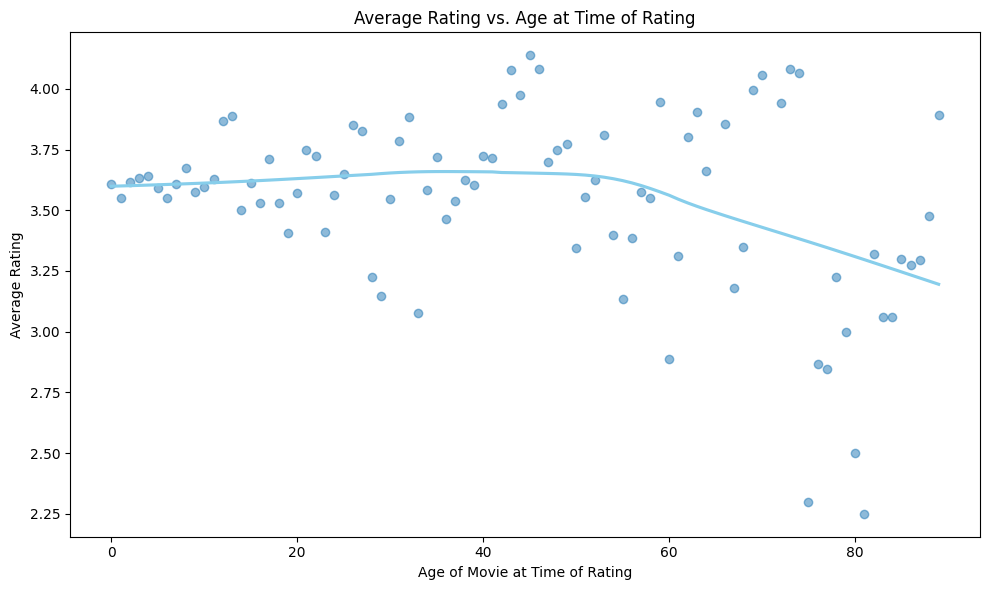

In [31]:
plt.figure(figsize=(10,6))
sns.regplot(
    data=avg_rating_per_age,
    x=avg_rating_per_age.index,
    y='rating',
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'skyblue'},
    lowess=True
)

plt.xlabel('Age of Movie at Time of Rating')
plt.ylabel('Average Rating')
plt.title('Average Rating vs. Age at Time of Rating')
plt.tight_layout()
plt.show()